# 🧪 Lab: Modelling & Model Lifecycle — Predicting Plant Production (GIST Steel Dataset)

---

## 🎯 Learning Outcomes

By completing this lab, you will be able to:

- Prepare and analyse a dataset for modelling.  
- Train and evaluate regression models.  
- Apply cross-validation and hyperparameter tuning using scikit-learn.  
- Track experiments and store models using MLflow and/or Optuna.  
- Reflect on the practical aspects of managing the ML lifecycle.

---



## 🧩 1. Data Setup and Exploration
⏱ *Estimated time: 30–40 min*

### 🧭 Objective  
Understand the dataset structure and the target variable (“plant-level production”).

---

### **Task 1.1 – Load and Inspect Data**
- Load the GIST Steel dataset. 
- Display basic info (shape, column names, missing values, and data types).  
- Identify the target variable (production) and key features (capacity, ...).


#### Imports

In [32]:
# !uv add pandas numpy matplotlib seaborn scikit-learn mlflow optuna joblib fitter

In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

# Experiment tracking
import mlflow
import mlflow.sklearn
import optuna
import joblib
from fitter import Fitter

from scipy import stats

#### Hyperparameters

In [34]:
XLSX_DATA_PATH = Path("../lab1/data/dataSept2025.xlsx")
ON_COLAB = False # Put false if executed in another environement than Google Colab

#### Functions

In [35]:
def get_dataframe(file_path, sheet_names, key_col):
    """Load and merge any number of Excel sheets on a key column."""
    read_df = lambda s: pd.read_excel(file_path, sheet_name=s)
    dfs = [read_df(s) for s in sheet_names]
    
    if len(dfs) == 1:
        return dfs[0]
    
    for df in dfs:
        df.set_index(key_col, inplace=True)

    from functools import reduce
    merged_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), dfs)
    merged_df.reset_index(inplace=True)
    return merged_df


#### Run

In [36]:
# Task 1.1 - Load and Inspect Data
# Load the data
merged_df = get_dataframe(XLSX_DATA_PATH, ["Plant data", "Plant capacities and status"], "Plant ID")
production_df = get_dataframe(XLSX_DATA_PATH, ["Plant production"], "Plant ID")

In [37]:
# print number of duplicates of "Plant ID" in production_df
print(production_df["Plant ID"].duplicated().sum())

1308


In [38]:
merged_df.columns

Index(['Plant ID', 'Plant name (English)_x', 'Plant name (other language)_x',
       'Other plant names (English)', 'Other plant names (other language)',
       'Owner', 'Owner (other language)', 'Owner GEM ID', 'Owner PermID',
       'SOE Status', 'Parent', 'Parent GEM ID', 'Parent PermID',
       'Location address', 'Municipality', 'Subnational unit (province/state)',
       'Country/Area_x', 'Region', 'Other language location address',
       'Coordinates', 'Coordinate accuracy', 'GEM wiki page',
       'Plant age (years)', 'Announced date', 'Construction date',
       'Start date_x', 'Pre-retirement announcement date', 'Idled date',
       'Retired date', 'Ferronickel capacity (ttpa)',
       'Sinter plant capacity (ttpa)', 'Coking plant capacity (ttpa)',
       'Pelletizing plant capacity (ttpa)', 'Category steel product',
       'Steel products', 'Steel sector end users', 'Workforce size',
       'ISO 14001', 'ISO 50001', 'ResponsibleSteel Certification',
       'Main production 

In [39]:
production_df["Type of production"].value_counts()

Type of production
Crude steel production (ttpa)            462
EAF steel production (ttpa)              307
Iron production (ttpa)                   299
BF iron production (ttpa)                256
BOF steel production (ttpa)              230
Other/Unknown steel production (ttpa)     99
DRI iron production (ttpa)                90
Other/Unknown iron production (ttpa)      37
OHF steel production (ttpa)                3
Other/unknown steel production (ttpa)      1
Name: count, dtype: int64

In [40]:
# if duplicates:
if "Plant ID" in merged_df.columns and merged_df["Plant ID"].duplicated().sum() > 0:
    # Remove duplicate Plant IDs, keeping the row with Status 'operating' if available
    merged_df = merged_df.sort_values(by="Status", ascending=False, key=lambda x: x == "operating").drop_duplicates(subset="Plant ID", keep="first")

# If plant id is not index :
if "Plant ID" in merged_df.columns:
    # Set index to "Plant ID"
    merged_df.set_index("Plant ID", inplace=True)

# Display the first few rows of the DataFrame
merged_df.head()

,Plant name (English)_x,Plant name (other language)_x,Other plant names (English),Other plant names (other language),Owner,Owner (other language),Owner GEM ID,Owner PermID,SOE Status,Parent,...,Start date_y,Nominal crude steel capacity (ttpa),Nominal BOF steel capacity (ttpa),Nominal EAF steel capacity (ttpa),Nominal OHF steel capacity (ttpa),Other/unspecified steel capacity (ttpa),Nominal iron capacity (ttpa),Nominal BF capacity (ttpa),Nominal DRI capacity (ttpa),Other/unspecified iron capacity (ttpa)
Plant ID,,,,,,,,,,,,,,,,,,,,,
P100000120856,Hadeed Metal Manufacturing Co Damascus steel p...,شركة الصناعات المعدنية حديد,"Hadeed MMC, Hadid Hama",NaN,Hadeed Metal Manufacturing Co,NaN,E100000131111,unknown,NaN,Hadeed Metal Manufacturing Co [100.0%],...,2012,1400,NaN,1400,NaN,NaN,NaN,NaN,NaN,NaN
P100000121191,Shakambhari Ispat and Power Purulia Steel Plant,NaN,NaN,NaN,Shakambhari Ispat & Power Ltd,NaN,E100001012202,5063329547,NaN,Shakambhari Group,...,2001,531,NaN,NaN,NaN,531,544,NaN,544,NaN
P100000120833,SABIC Hadeed Al Jubail steel plant,حديد,"Saudi Iron & Steel Company, Hadeed",NaN,Saudi Iron and Steel Co,NaN,E100000130924,5000051849,Full,Saudi Iron and Steel Co [100.0%],...,1979,6000,NaN,6000,NaN,NaN,5300,NaN,5300,NaN
P100000120837,Rajhi Al Assemah Steel Jeddah plant,حديد الراجحي,Rajhi Steel,NaN,Rajhi Steel Industries Co Ltd,NaN,E100000130969,5034762548,Full,Saudi Iron and Steel Co [100.0%],...,1984,850,NaN,850,NaN,NaN,NaN,NaN,NaN,NaN
P100000120075,Sichuan Desheng Group Vanadium and Titanium Co...,四川德胜集团钒钛有限公司,"Sichuan Desheng Group Steel Co., Ltd.",四川德胜集团钢铁有限公司,"Sichuan De Sheng Group, Vanadium and Titanium ...",四川德胜集团钒钛有限公司,E100000126458,unknown,NaN,Haojun Development Group Co Ltd [49.0%]; natur...,...,1997,3000,3000.0,NaN,NaN,NaN,2250,2250,NaN,NaN


In [41]:
# Group by "Plant ID" and list "Type of production" values, then get the lists of values, display number of rows without "Crude steel production (ttpa)" in list
grouped_types = production_df.groupby("Plant ID")["Type of production"].apply(list)
no_crude_idx = grouped_types.apply(lambda types: "Crude steel production (ttpa)" not in types)
print(no_crude_idx.sum())

14


In [42]:
# If there are duplicates in production_df by "Plant ID", keep only the row with "Type of production" == "Crude steel production (ttpa)"
if production_df["Plant ID"].duplicated().sum() > 0:

    crude_mask = production_df["Type of production"] == "Crude steel production (ttpa)"
    # Keep only the "Crude steel production (ttpa)" rows for duplicated Plant IDs
    # For Plant IDs with only other types, all rows will be dropped for that Plant ID
    production_df = production_df[crude_mask | ~production_df["Plant ID"].duplicated(keep=False)]

In [43]:
merged_df = pd.merge(merged_df, production_df, on="Plant ID")

# Convert all column names to strings
merged_df.columns = merged_df.columns.map(str)

print("Dataset shape:", merged_df.shape)
print("\nColumn names:")
print(merged_df.columns.tolist())
print("\nData types:")
print(merged_df.dtypes.value_counts())
print("\nMissing values per column:")
print(merged_df.isnull().sum().sort_values(ascending=False).head(10))


Dataset shape: (462, 66)

Column names:
['Plant ID', 'Plant name (English)_x', 'Plant name (other language)_x', 'Other plant names (English)', 'Other plant names (other language)', 'Owner', 'Owner (other language)', 'Owner GEM ID', 'Owner PermID', 'SOE Status', 'Parent', 'Parent GEM ID', 'Parent PermID', 'Location address', 'Municipality', 'Subnational unit (province/state)', 'Country/Area_x', 'Region', 'Other language location address', 'Coordinates', 'Coordinate accuracy', 'GEM wiki page', 'Plant age (years)', 'Announced date', 'Construction date', 'Start date_x', 'Pre-retirement announcement date', 'Idled date', 'Retired date', 'Ferronickel capacity (ttpa)', 'Sinter plant capacity (ttpa)', 'Coking plant capacity (ttpa)', 'Pelletizing plant capacity (ttpa)', 'Category steel product', 'Steel products', 'Steel sector end users', 'Workforce size', 'ISO 14001', 'ISO 50001', 'ResponsibleSteel Certification', 'Main production equipment', 'Power source', 'Iron ore source', 'Met coal source'


> 📝 *Markdown prompt:*  
Describe any patterns or potential data quality issues you notice. Which variables might strongly influence production?

---

### **Task 1.2 – Data Cleaning**
- Handle missing values appropriately (e.g., imputation, removal).  
- Check for outliers or incorrect entries in numerical columns.  
- Apply transformations if needed (e.g., log-transform for skewed distributions).

> 📝 *Markdown prompt:*  
Explain your cleaning choices. Why did you treat the missing or skewed data in that way?

---


#### Functions

In [44]:
def replace_with_nan(df, key="unknown"):
    """Replace string values with NaN"""
    return df.replace(key, np.nan)

def clean_numerical_columns(df, numerical_cols):
    """Convert string columns to numeric, invalid values become NaN"""
    df_clean = df.copy()
    for col in numerical_cols:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    return df_clean


In [45]:
def plot_numeric_distributions(df, numeric_cols=None, bins=30, figsize=(20, 15)):
    """
    Plot histograms of all numeric features in the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        numeric_cols (list, optional): List of columns to plot. If None, selects all numeric columns.
        bins (int): Number of bins for the histograms.
        figsize (tuple): Size of the entire figure.
    """
    import matplotlib.pyplot as plt

    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    n_cols = 3
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    plt.figure(figsize=figsize)
    for idx, col in enumerate(numeric_cols):
        plt.subplot(n_rows, n_cols, idx + 1)
        df[col].hist(bins=bins, edgecolor='black')
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

#### Run

In [46]:
# Task 1.2 - Data Cleaning
# Replace "unknown" strings with NaN
merged_df = replace_with_nan(merged_df, "unknown")

# Identify numerical columns (capacity, workforce, age, production years)
numerical_cols = [
    'Nominal crude steel capacity (ttpa)', 'Nominal BOF steel capacity (ttpa)', 
    'Nominal EAF steel capacity (ttpa)', 'Other/unspecified steel capacity (ttpa)',
    'Nominal iron capacity (ttpa)', 'Nominal BF capacity (ttpa)', 'Nominal DRI capacity (ttpa)',
    'Other/unspecified iron capacity (ttpa)', 'Nominal OHF steel capacity (ttpa)',
    'Workforce size', 'Plant age (years)', '2019', '2020', '2021', '2022', '2023'
]

# Clean numerical columns
merged_df = clean_numerical_columns(merged_df, numerical_cols)

print("After cleaning - Missing values in key columns:")
key_cols = ['2023', 'Nominal crude steel capacity (ttpa)', 'Workforce size', 'Plant age (years)', 'Region']
for col in key_cols:
    if col in merged_df.columns:
        print(f"{col}: {merged_df[col].isnull().sum()} missing")

# Check for outliers in key numerical columns
print("\nOutlier detection (using IQR method):")
for col in ['2023', 'Nominal crude steel capacity (ttpa)', 'Workforce size']:
    if col in merged_df.columns and merged_df[col].dtype in ['float64', 'int64']:
        Q1 = merged_df[col].quantile(0.25)
        Q3 = merged_df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = merged_df[(merged_df[col] < Q1 - 1.5*IQR) | (merged_df[col] > Q3 + 1.5*IQR)]
        print(f"{col}: {len(outliers)} outliers out of {len(merged_df)} total")

After cleaning - Missing values in key columns:
2023: 195 missing
Nominal crude steel capacity (ttpa): 14 missing
Workforce size: 25 missing
Plant age (years): 7 missing
Region: 0 missing

Outlier detection (using IQR method):
2023: 24 outliers out of 462 total
Nominal crude steel capacity (ttpa): 32 outliers out of 462 total
Workforce size: 31 outliers out of 462 total


In [47]:
'Nominal crude steel capacity (ttpa)' in merged_df.columns

True

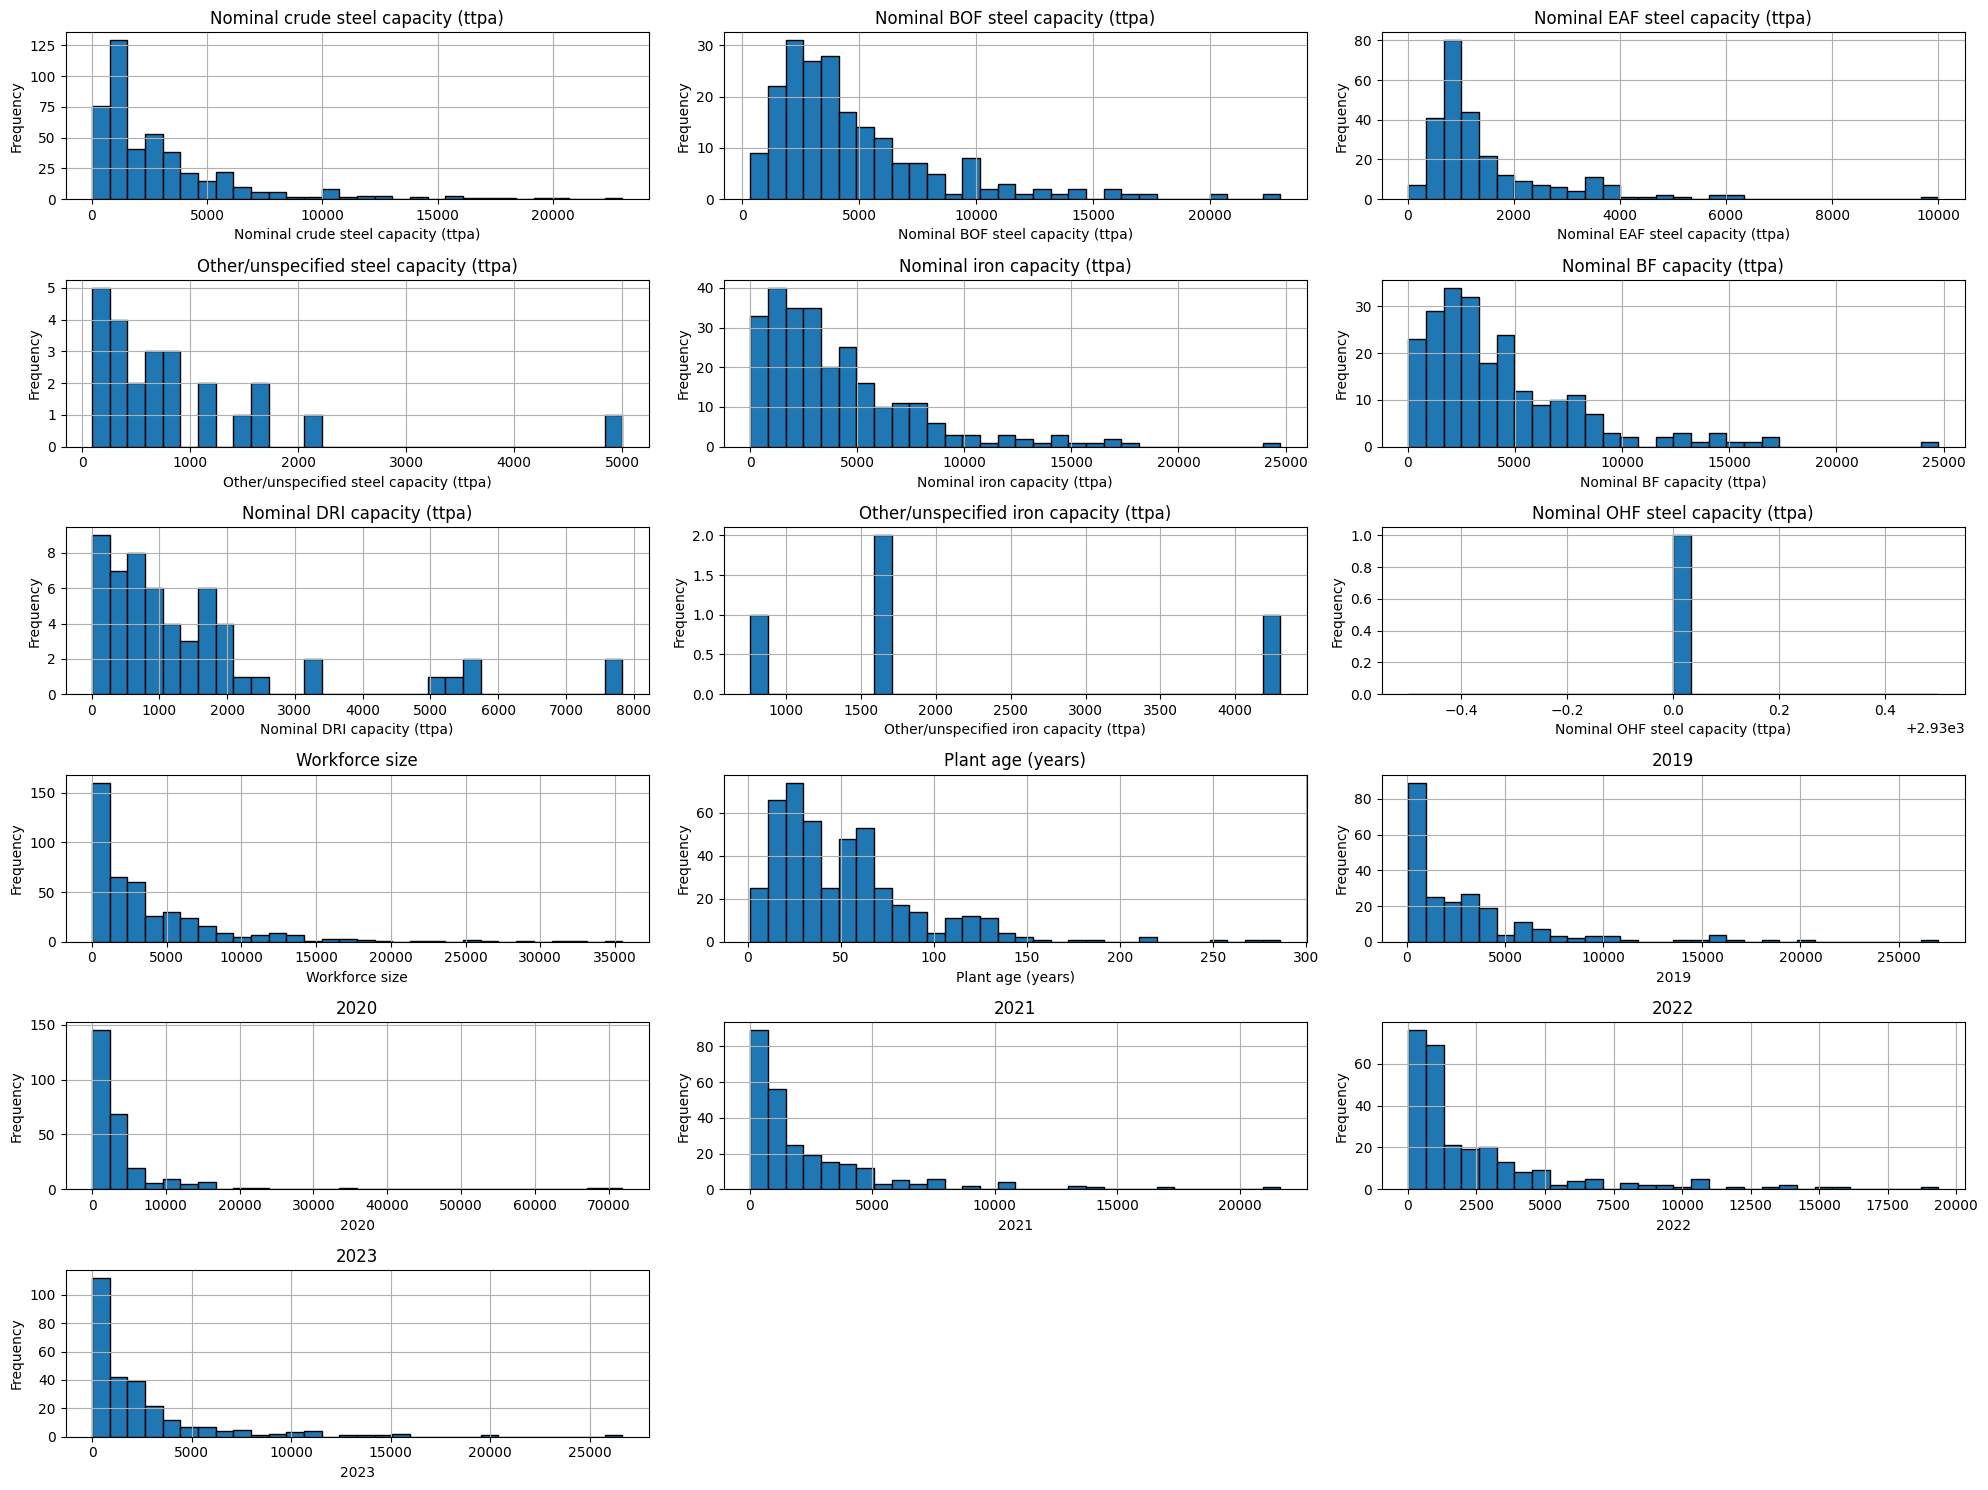

In [48]:
plot_numeric_distributions(merged_df, numeric_cols=numerical_cols)



### **Task 1.3 – Feature Engineering**
- Create at least two new variables that might improve model performance (e.g., “capacity per worker”, “energy efficiency”).  
- Encode categorical variables and standardize numeric ones.
- Bonus: you are free to use external socioeconomic or environmental data sources to enhance your feature set.

> 📝 *Markdown prompt:*  
Document your new feature(s). What business or operational insight do they represent?

---


#### Functions

In [49]:
def create_engineered_features(df):
    """Create new features that might improve model performance"""
    df_fe = df.copy()
    
    # Feature 1: Capacity per worker
    if 'Nominal crude steel capacity (ttpa)' in df_fe.columns and 'Workforce size' in df_fe.columns:
        df_fe['capacity_per_worker'] = df_fe['Nominal crude steel capacity (ttpa)'] / df_fe['Workforce size']
        df_fe['capacity_per_worker'].replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Feature 2: Capacity × Age
    if 'Nominal crude steel capacity (ttpa)' in df_fe.columns and 'Plant age (years)' in df_fe.columns:
        df_fe['capacity_x_age'] = df_fe['Nominal crude steel capacity (ttpa)'] * df_fe['Plant age (years)']
    
    # Feature 3: Production trend (if using time-series approach)
    if all(col in df_fe.columns for col in ['2022', '2019']):
        df_fe['production_trend'] = (df_fe['2022'] - df_fe['2019']) / 3
    
    return df_fe

# def scale transform
def scale_transform(df, cols):
    for col in cols:
        if col in df.columns and df[col].dtype in ['float64', 'int64']:
            scaler = StandardScaler()
            df[f'scaled_{col}'] = scaler.fit_transform(df[[col]].fillna(0))
    return df, f'scaled_{col}'

# def lof transform
def log_scale_transform(df, cols):
    for col in cols:
        if col in df.columns and df[col].dtype in ['float64', 'int64']:
            df[f'log_{col}'] = np.log1p(df[col])
            
            df, col_name = scale_transform(df, [f'log_{col}'])
    return df, col_name

# sqrt scale transform
def sqrt_scale_transform(df, cols):
    for col in cols:
        if col in df.columns and df[col].dtype in ['float64', 'int64']:
            df[f'sqrt_{col}'] = np.sqrt(df[col])
            df, col_name = scale_transform(df, [f'sqrt_{col}'])
    return df, col_name

#### Run

In [50]:
# Task 1.3 - Feature Engineering
# Create engineered features
merged_df = create_engineered_features(merged_df)

# Encode categorical variables
categorical_cols = ['Region', 'Country/Area_x']
for col in categorical_cols:
    if col in merged_df.columns:
        le = LabelEncoder()
        merged_df[f'{col}_encoded'] = le.fit_transform(merged_df[col].astype(str))

print("Created engineered features:")
engineered_features = ['capacity_per_worker', 'capacity_x_age', 'production_trend']
for feat in engineered_features:
    if feat in merged_df.columns:
        print(f"- {feat}: {merged_df[feat].notna().sum()} non-null values")

Created engineered features:
- capacity_per_worker: 426 non-null values
- capacity_x_age: 442 non-null values
- production_trend: 157 non-null values


In [51]:
# Ensure numerical_cols exists (otherwise derive it, e.g. all numeric columns except encoded/categorical)
if 'numerical_cols' not in locals():
    numerical_cols = [col for col in merged_df.columns if merged_df[col].dtype in [float, int] and not any(x in col for x in ['encoded', 'Region', 'Country', 'log_', 'sqrt_', 'scaled_'])]

dist_fit_results = {}
transformed_cols = []

for col in numerical_cols:
    data = merged_df[col].dropna()
    if data.empty:
        print(f"Skipping {col} because it has no data")
        continue

    # Fit distributions
    # NOTE: stats.poisson.fit does NOT exist! For Poisson, estimate the mean (lambda) as sample mean.
    poisson_mu = data.mean()  # Poisson MLE for lambda is sample mean
    poisson_params = (poisson_mu,)

    normal_params = stats.norm.fit(data)
    expon_params = stats.expon.fit(data)

    # Goodness of fit tests
    # For Poisson, need integer data for a sensible test
    if np.allclose(data, np.round(data)):
        ks_poisson = stats.kstest(data, 'poisson', args=poisson_params)
        p_poisson = ks_poisson.pvalue
    else:
        p_poisson = -1  # Not a valid test on non-integer data

    ks_normal = stats.kstest(data, 'norm', args=normal_params)
    ks_expon = stats.kstest(data, 'expon', args=expon_params)
    
    p_normal = ks_normal.pvalue
    p_expon = ks_expon.pvalue

    print(f"\nColumn: {col} | ", end = "")
    print(f"Poisson p-value: {p_poisson if p_poisson >= 0 else 'N/A (not integer data)'} | ", end = "")
    print(f"Normal p-value: {p_normal:.4f} | ", end = "")
    print(f"Exponential p-value: {p_expon:.4f}")
    
    # Find best-fit based on p-value
    # Only include poisson if test was run
    pvals = []
    pnames = []
    if p_poisson >= 0:
        pvals.append(p_poisson)
        pnames.append("poisson")
    pvals.extend([p_normal, p_expon])
    pnames.extend(["normal", "exponential"])
    idx_best = np.argmax(pvals)
    best_fit = pnames[idx_best]

    if best_fit == 'poisson':
        print(f"==> Best fit: Poisson, applying log+scaling")
        merged_df, col_name = log_scale_transform(merged_df, [col])
    elif best_fit == 'normal':
        print(f"==> Best fit: Normal, applying standard scaling")
        merged_df, col_name = scale_transform(merged_df, [col])
    else:
        print(f"==> Best fit: Exponential, applying sqrt+scaling")
        merged_df, col_name = sqrt_scale_transform(merged_df, [col])

    dist_fit_results[col] = {
        'poisson_p': p_poisson, 'normal_p': p_normal, 'expon_p': p_expon, 'best_fit': best_fit
    }
    
    transformed_cols.append(col_name)
    
print(f"\nApplied transformation to {len(transformed_cols)} features")


Column: Nominal crude steel capacity (ttpa) | Poisson p-value: 7.67625174713129e-177 | Normal p-value: 0.0000 | Exponential p-value: 0.0000
==> Best fit: Exponential, applying sqrt+scaling

Column: Nominal BOF steel capacity (ttpa) | Poisson p-value: 2.902078250586207e-82 | Normal p-value: 0.0000 | Exponential p-value: 0.0001
==> Best fit: Exponential, applying sqrt+scaling

Column: Nominal EAF steel capacity (ttpa) | Poisson p-value: 4.87299691693714e-118 | Normal p-value: 0.0000 | Exponential p-value: 0.0000
==> Best fit: Normal, applying standard scaling

Column: Other/unspecified steel capacity (ttpa) | Poisson p-value: 5.036418258845149e-11 | Normal p-value: 0.2008 | Exponential p-value: 0.6239
==> Best fit: Exponential, applying sqrt+scaling

Column: Nominal iron capacity (ttpa) | Poisson p-value: 9.448387181535155e-93 | Normal p-value: 0.0000 | Exponential p-value: 0.0522
==> Best fit: Exponential, applying sqrt+scaling

Column: Nominal BF capacity (ttpa) | Poisson p-value: 5.3

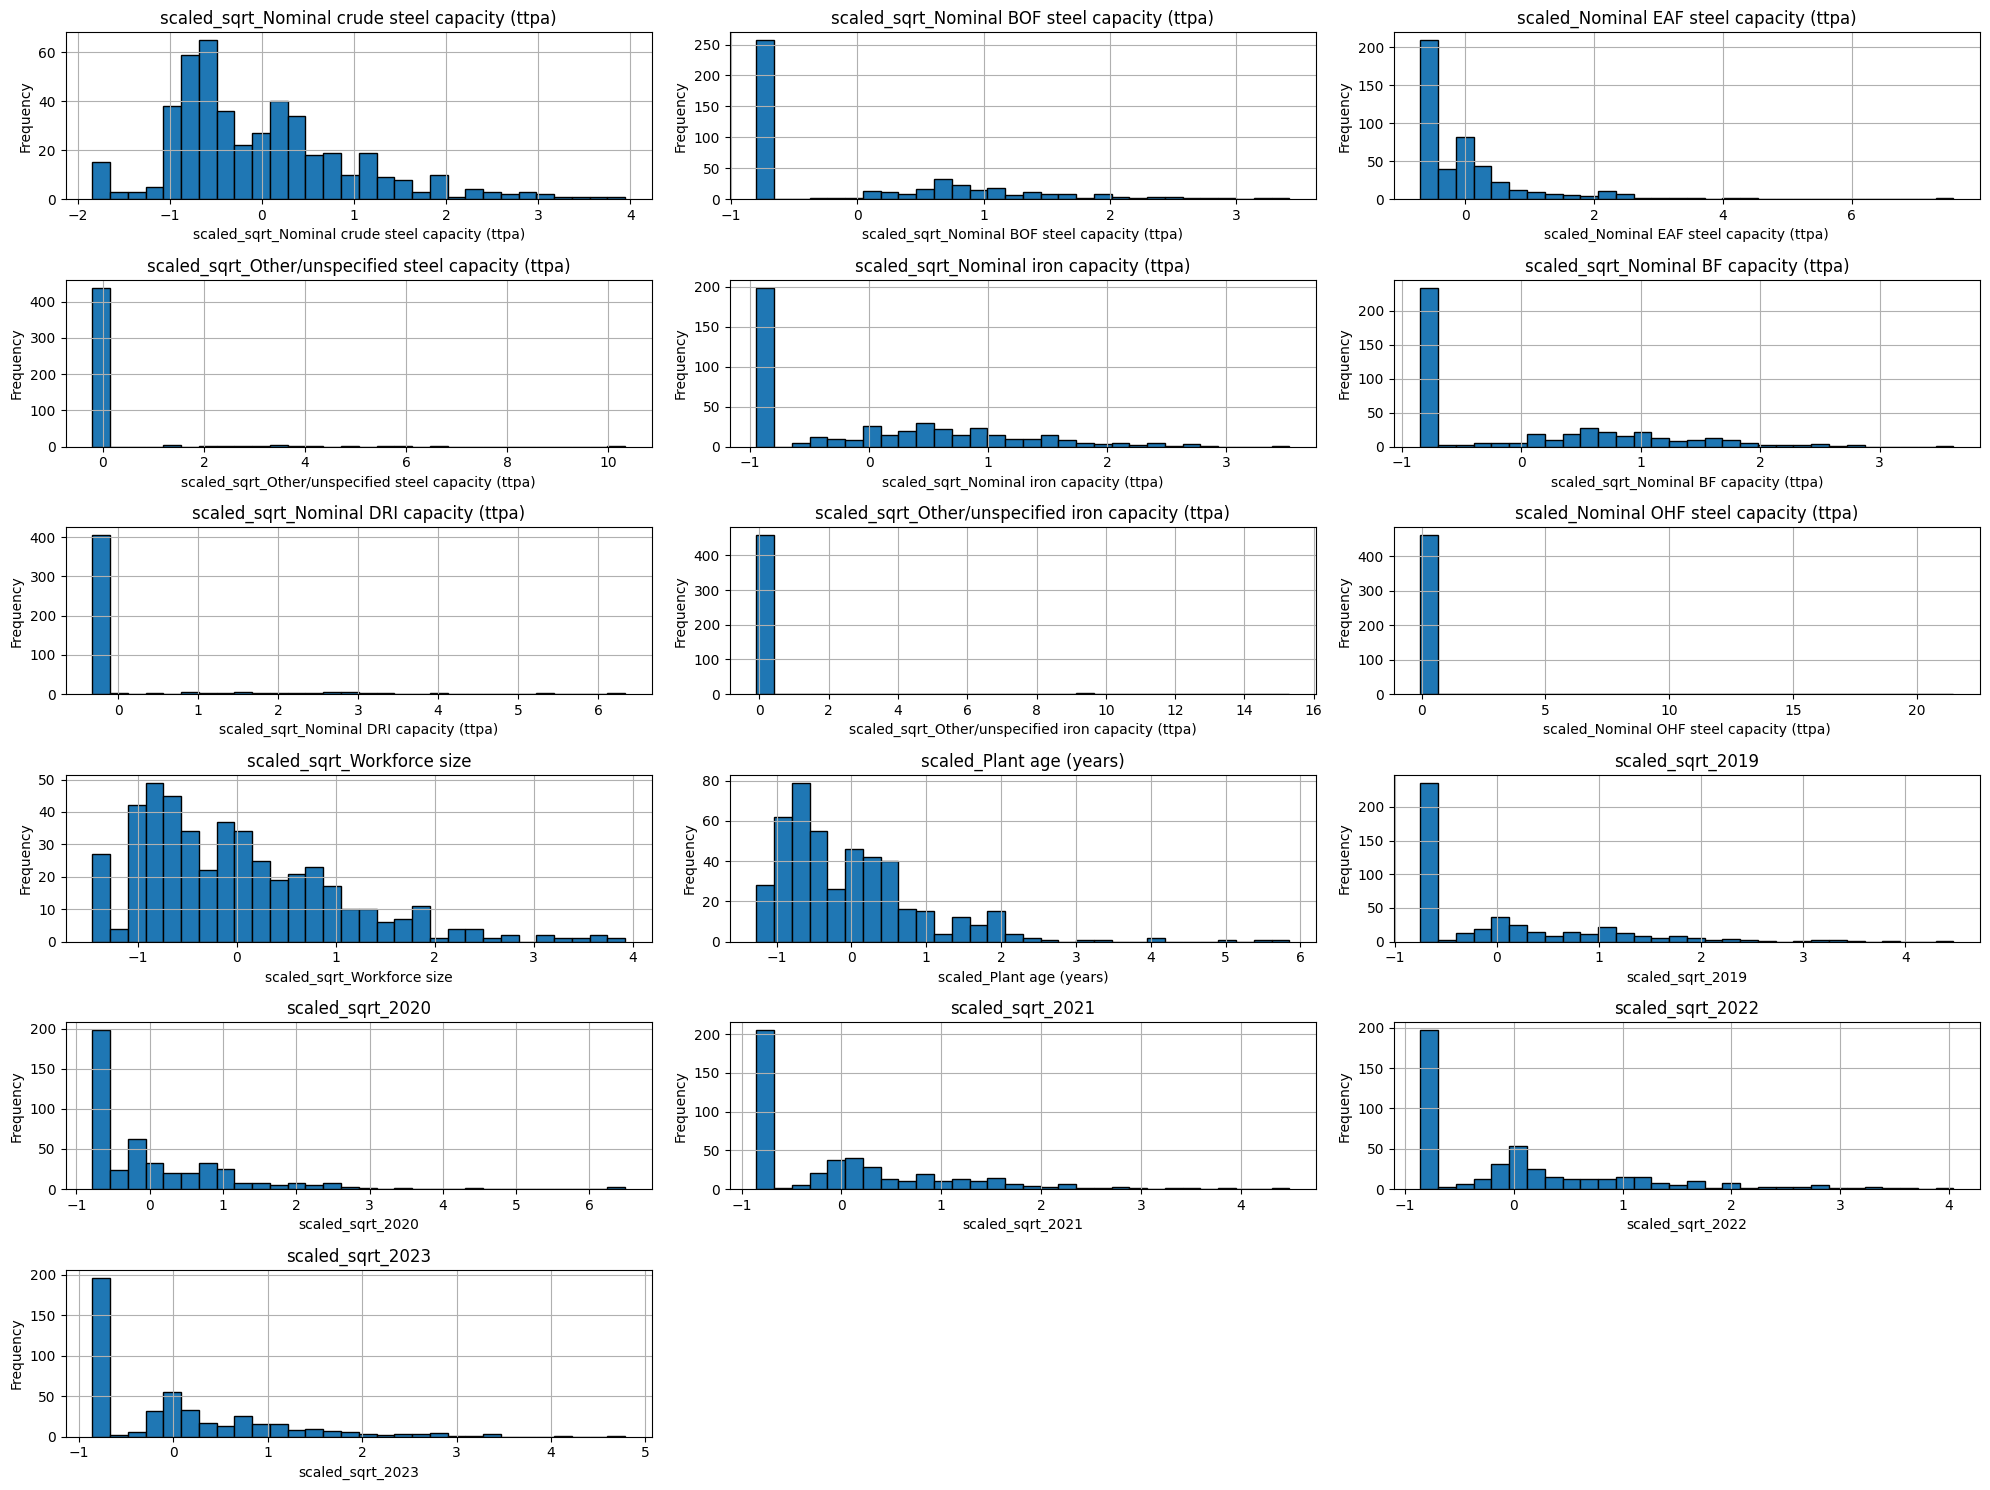

In [52]:
plot_numeric_distributions(merged_df, numeric_cols=transformed_cols)


## 🔍 1.4 Feature Relationships and Correlations
⏱ *Estimated time: 20–25 min*

### 🧭 Objective  
Before training models, it’s essential to understand how features relate to each other and to the target variable — both linearly and nonlinearly. This helps identify redundant or uninformative predictors and guides model choice.

---

### **Task 1.4.1 – Correlation Matrix (Linear Relationships)**
- Compute a **correlation matrix** (e.g., using `df.corr()`, `seaborn.heatmap`, `skrub`) to examine pairwise linear relationships among numerical features.  
- Focus on correlations between each feature and the target (`production`), as well as between features themselves.

> 📝 *Markdown prompt:*  
Which variables show the strongest correlation with production?  
Do any features appear redundant or highly correlated with each other?

---


Top correlations with 2023 production:
2023                                               1.000000
2022                                               0.977466
2019                                               0.970938
scaled_sqrt_2023                                   0.954322
2021                                               0.951623
scaled_sqrt_Nominal crude steel capacity (ttpa)    0.863248
2020                                               0.802906
scaled_sqrt_Nominal iron capacity (ttpa)           0.794196
scaled_sqrt_Nominal BF capacity (ttpa)             0.790928
scaled_sqrt_Nominal BOF steel capacity (ttpa)      0.786168
Name: 2023, dtype: float64


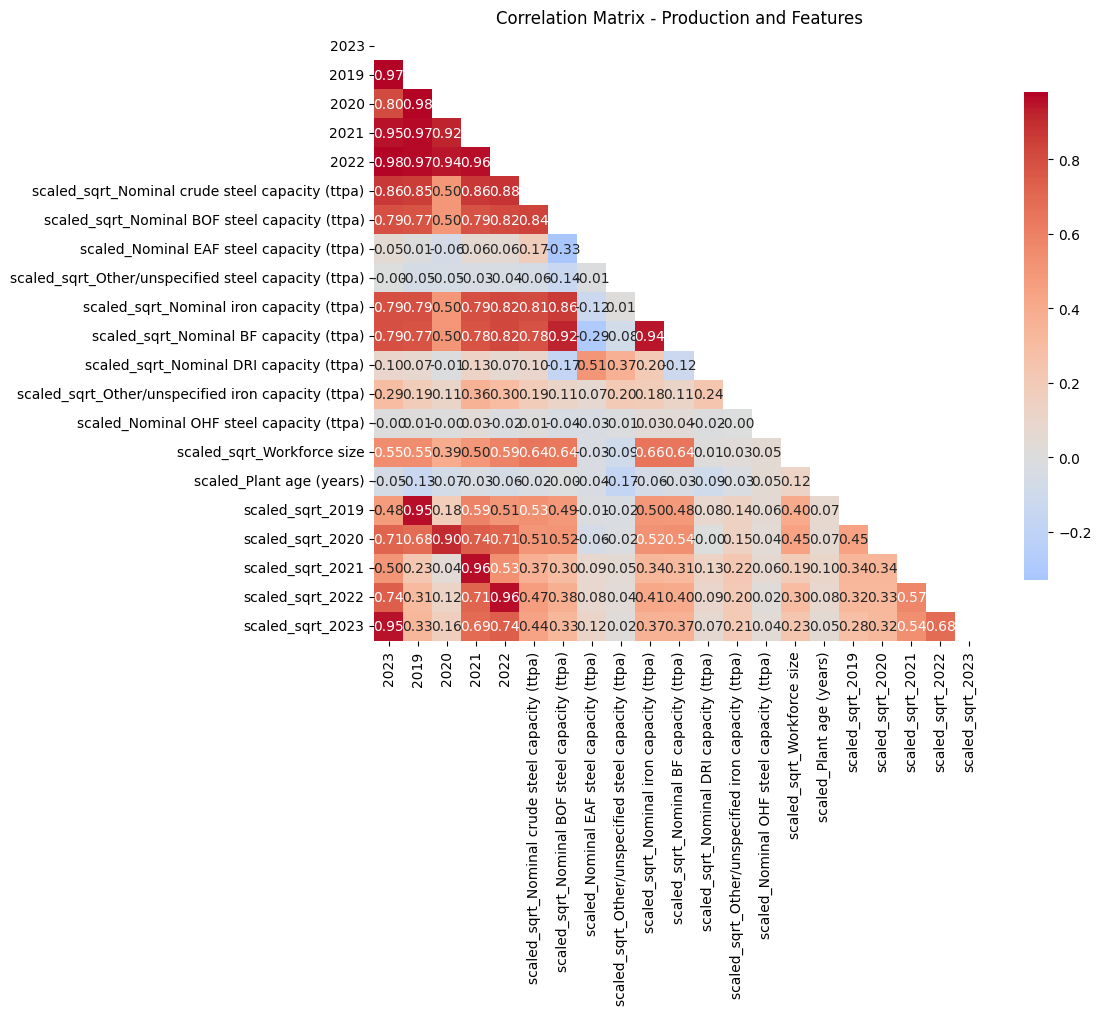


Highly correlated feature pairs (|r| > 0.7): 43
2023 - 2019: 0.971
2023 - 2020: 0.803
2023 - 2021: 0.952
2023 - 2022: 0.977
2023 - scaled_sqrt_Nominal crude steel capacity (ttpa): 0.863


In [53]:
# Task 1.4 - Correlation Analysis
# Prepare data for correlation analysis
correlation_cols = ['2023'] + [str(col) for col in merged_df.columns if (col in ['2019', '2020', '2021', '2022'] + transformed_cols)]
correlation_data = merged_df[correlation_cols].select_dtypes(include=[np.number])

# Compute correlation matrix
correlation_matrix = correlation_data.corr()

# Focus on correlations with target (2023)
target_correlations = correlation_matrix['2023'].sort_values(ascending=False)
print("Top correlations with 2023 production:")
print(target_correlations.head(10))

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix - Production and Features')
plt.tight_layout()
plt.show()

# Identify highly correlated features
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7 and not pd.isna(corr_val):
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val))

print(f"\nHighly correlated feature pairs (|r| > 0.7): {len(high_corr_pairs)}")
for pair in high_corr_pairs[:5]:  # Show top 5
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")


## 🧮 2. Building Baseline & Linear Models
⏱ *Estimated time: 25–30 min*

### 🧭 Objective  
Establish a simple baseline, then train and interpret a linear model.

---

### **Task 2.1 – Baseline**
- Compute a simple baseline predictor (e.g., mean or median production).  
- Measure RMSE or MAE compared to actual values.

> 📝 *Markdown prompt:*  
Why is it useful to have a baseline model before trying more complex ones?

---


In [54]:
# Task 2.1 - Baseline Model
# Prepare data - remove rows with missing target
df_clean = merged_df.dropna(subset=['2023']).copy()

# Split data
X = df_clean.drop(['2023'], axis=1)
y = df_clean['2023']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Baseline: Mean of Region for 2022 production
if 'Region' in X_train.columns and '2022' in X_train.columns:
    # Calculate regional means for 2022
    regional_means = X_train.groupby('Region')['2022'].mean()
    
    # Create baseline predictions
    baseline_pred_train = X_train['Region'].map(regional_means)
    baseline_pred_test = X_test['Region'].map(regional_means)
    
    # Fill missing regions with overall mean
    baseline_pred_train = baseline_pred_train.fillna(X_train['2022'].mean())
    baseline_pred_test = baseline_pred_test.fillna(X_train['2022'].mean())
    
    # Calculate baseline metrics
    baseline_rmse_train = np.sqrt(mean_squared_error(y_train, baseline_pred_train))
    baseline_mae_train = mean_absolute_error(y_train, baseline_pred_train)
    baseline_r2_train = r2_score(y_train, baseline_pred_train)
    
    baseline_rmse_test = np.sqrt(mean_squared_error(y_test, baseline_pred_test))
    baseline_mae_test = mean_absolute_error(y_test, baseline_pred_test)
    baseline_r2_test = r2_score(y_test, baseline_pred_test)
    
    print(f"\nBaseline Model Performance:")
    print(f"Training - RMSE: {baseline_rmse_train:.2f}, MAE: {baseline_mae_train:.2f}, R²: {baseline_r2_train:.3f}")
    print(f"Test - RMSE: {baseline_rmse_test:.2f}, MAE: {baseline_mae_test:.2f}, R²: {baseline_r2_test:.3f}")
else:
    print("Warning: Region or 2022 column not found for baseline model")


Training set: 213 samples
Test set: 54 samples

Baseline Model Performance:
Training - RMSE: 3369.96, MAE: 2105.82, R²: 0.119
Test - RMSE: 2491.26, MAE: 1931.19, R²: -0.027



### **Task 2.2 – Linear Regression**
- Train a multiple linear regression model using the key plant variables.  
- Display coefficients and interpret their meaning.  
- Evaluate the model on training and test data.

> 📝 *Markdown prompt:*  
Interpret one positive and one negative coefficient. What do they tell you about plant performance drivers?

---


In [55]:
# Task 2.2 - Linear Regression
# Prepare features for linear regression (use scaled features)
feature_cols = [col for col in X_train.columns if col in ['2019', '2020', '2021', '2022'] + transformed_cols]
feature_cols = [col for col in feature_cols if col in X_train.columns]

# Handle missing values in features
X_train_features = X_train[feature_cols].fillna(0)
X_test_features = X_test[feature_cols].fillna(0)

# Train linear regression
lr_model = LinearRegression()
lr_model.fit(X_train_features, y_train)

# Make predictions
lr_pred_train = lr_model.predict(X_train_features)
lr_pred_test = lr_model.predict(X_test_features)

# Calculate metrics
lr_rmse_train = np.sqrt(mean_squared_error(y_train, lr_pred_train))
lr_mae_train = mean_absolute_error(y_train, lr_pred_train)
lr_r2_train = r2_score(y_train, lr_pred_train)

lr_rmse_test = np.sqrt(mean_squared_error(y_test, lr_pred_test))
lr_mae_test = mean_absolute_error(y_test, lr_pred_test)
lr_r2_test = r2_score(y_test, lr_pred_test)

print(f"Linear Regression Performance:")
print(f"Training - RMSE: {lr_rmse_train:.2f}, MAE: {lr_mae_train:.2f}, R²: {lr_r2_train:.3f}")
print(f"Test - RMSE: {lr_rmse_test:.2f}, MAE: {lr_mae_test:.2f}, R²: {lr_r2_test:.3f}")

# Display feature coefficients
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lr_model.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print(f"\nTop 10 most important features:")
print(feature_importance.head(10))

# Compare with baseline
print(f"\nImprovement over baseline:")
print(f"RMSE improvement: {((baseline_rmse_test - lr_rmse_test) / baseline_rmse_test * 100):.1f}%")
print(f"R² improvement: {((lr_r2_test - baseline_r2_test) / abs(baseline_r2_test) * 100):.1f}%")


Linear Regression Performance:
Training - RMSE: 533.81, MAE: 357.30, R²: 0.978
Test - RMSE: 799.42, MAE: 437.73, R²: 0.894

Top 10 most important features:
                                          feature  coefficient
19                               scaled_sqrt_2023  2445.593014
18                               scaled_sqrt_2022 -1887.157283
9          scaled_sqrt_Nominal BF capacity (ttpa)  -776.687349
8        scaled_sqrt_Nominal iron capacity (ttpa)   641.802417
17                               scaled_sqrt_2021   418.039054
5   scaled_sqrt_Nominal BOF steel capacity (ttpa)  -287.648260
6        scaled_Nominal EAF steel capacity (ttpa)  -281.456091
15                               scaled_sqrt_2019   251.546783
10        scaled_sqrt_Nominal DRI capacity (ttpa)  -150.829209
16                               scaled_sqrt_2020   -89.704213

Improvement over baseline:
RMSE improvement: 67.9%
R² improvement: 3368.2%


## 🔁 3. Model Evaluation and Selection
⏱ *Estimated time: 45–60 min*

### 🧭 Objective  
Use cross-validation to estimate generalization performance and compare multiple model types.

---

### **Task 3.1 – Cross-Validation**
- Apply **K-Fold cross-validation** (e.g., K=5).  
- Record the average RMSE, MAE, and R² across folds.

> 📝 *Markdown prompt:*  
Summarize your results. How stable is performance across folds? What might this indicate about model variance?

---


Cross-Validation Results (5-fold):
RMSE - Mean: 922.93, Std: 448.85
MAE - Mean: 498.29, Std: 102.45
R² - Mean: 0.925, Std: 0.043

Stability Analysis:
RMSE CV: 48.6%
R² CV: 4.6%


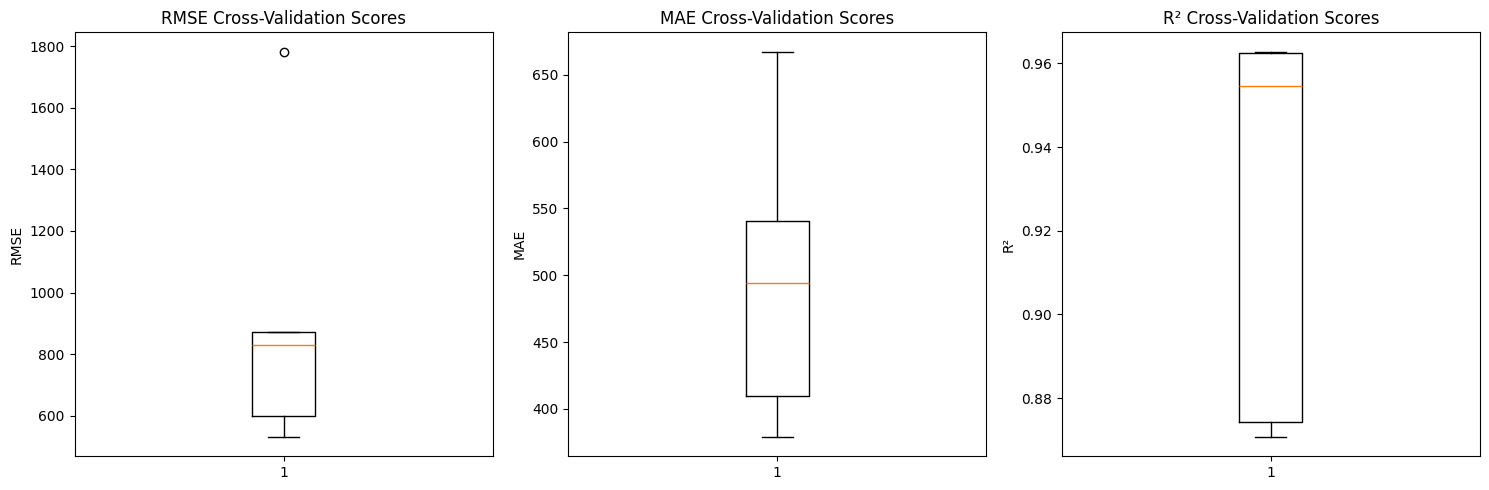

In [56]:
# Task 3.1 - Cross-Validation
# Apply 5-fold cross-validation on Linear Regression
cv_scores_rmse = cross_val_score(lr_model, X_train_features, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_mae = cross_val_score(lr_model, X_train_features, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_scores_r2 = cross_val_score(lr_model, X_train_features, y_train, cv=5, scoring='r2')

# Convert to positive values for RMSE and MAE
cv_rmse_scores = np.sqrt(-cv_scores_rmse)
cv_mae_scores = -cv_scores_mae

print("Cross-Validation Results (5-fold):")
print(f"RMSE - Mean: {cv_rmse_scores.mean():.2f}, Std: {cv_rmse_scores.std():.2f}")
print(f"MAE - Mean: {cv_mae_scores.mean():.2f}, Std: {cv_mae_scores.std():.2f}")
print(f"R² - Mean: {cv_scores_r2.mean():.3f}, Std: {cv_scores_r2.std():.3f}")

# Analyze stability
print(f"\nStability Analysis:")
print(f"RMSE CV: {cv_rmse_scores.std() / cv_rmse_scores.mean() * 100:.1f}%")
print(f"R² CV: {cv_scores_r2.std() / abs(cv_scores_r2.mean()) * 100:.1f}%")

# Visualize cross-validation scores
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].boxplot(cv_rmse_scores)
axes[0].set_title('RMSE Cross-Validation Scores')
axes[0].set_ylabel('RMSE')

axes[1].boxplot(cv_mae_scores)
axes[1].set_title('MAE Cross-Validation Scores')
axes[1].set_ylabel('MAE')

axes[2].boxplot(cv_scores_r2)
axes[2].set_title('R² Cross-Validation Scores')
axes[2].set_ylabel('R²')

plt.tight_layout()
plt.show()


### **Task 3.2 – Model Comparison**
Train and compare at least **three models**:
- Linear Regression  
- Ridge Regression (regularized linear)  
- Random Forest Regressor  

Record cross-validation performance for each model.

> 📝 *Markdown prompt:*  
Create a small results table. Which model performs best? Why might that be the case given the dataset’s characteristics?

---

#### Functions

In [57]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Evaluate a model and return metrics"""
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    train_mae = mean_absolute_error(y_train, train_pred)
    train_r2 = r2_score(y_train, train_pred)
    
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    test_mae = mean_absolute_error(y_test, test_pred)
    test_r2 = r2_score(y_test, test_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)
    
    return {
        'model_name': model_name,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_r2': train_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'cv_rmse_mean': cv_rmse.mean(),
        'cv_rmse_std': cv_rmse.std()
    }

#### Run

In [58]:
# Task 3.2 - Model Comparison

# Define models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Evaluate all models
results = []
for name, model in models.items():
    result = evaluate_model(model, X_train_features, y_train, X_test_features, y_test, name)
    results.append(result)

# Create results DataFrame
results_df = pd.DataFrame(results)
print("Model Comparison Results:")
print(results_df[['model_name', 'test_rmse', 'test_mae', 'test_r2', 'cv_rmse_mean', 'cv_rmse_std']].round(3))

# Time-series model (using 2019-2022 as features)
ts_features = ['2019', '2020', '2021', '2022']
ts_feature_cols = [col for col in ts_features if col in X_train.columns]

if len(ts_feature_cols) > 0:
    X_train_ts = X_train[ts_feature_cols].fillna(0)
    X_test_ts = X_test[ts_feature_cols].fillna(0)
    
    ts_model = LinearRegression()
    ts_result = evaluate_model(ts_model, X_train_ts, y_train, X_test_ts, y_test, 'Time-Series (2019-2022)')
    results.append(ts_result)
    
    print(f"\nTime-Series Model Results:")
    print(f"Test RMSE: {ts_result['test_rmse']:.2f}, MAE: {ts_result['test_mae']:.2f}, R²: {ts_result['test_r2']:.3f}")

# Find best model
best_model_idx = results_df['test_r2'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'model_name']
print(f"\nBest performing model: {best_model_name}")
print(f"Test R²: {results_df.loc[best_model_idx, 'test_r2']:.3f}")


Model Comparison Results:
          model_name  test_rmse  test_mae  test_r2  cv_rmse_mean  cv_rmse_std
0  Linear Regression    799.419   437.725    0.894       922.933      448.849
1   Ridge Regression    799.599   416.101    0.894       904.633      471.995
2      Random Forest    175.174    69.846    0.995       612.451      654.887

Time-Series Model Results:
Test RMSE: 1861.27, MAE: 889.54, R²: 0.427

Best performing model: Random Forest
Test R²: 0.995


### **Task 3.3 – Hyperparameter Optimization**
- Use **RandomizedSearchCV** or **GridSearchCV** to tune the top model (e.g., Random Forest).  
- Report the best parameters and corresponding validation score.

> 📝 *Markdown prompt:*  
Discuss the role of hyperparameter tuning. How did tuning change your model’s performance compared to default settings?

---


In [59]:
# Task 3.3 - Hyperparameter Tuning
# Tune the best model (likely Random Forest)
print("Hyperparameter Tuning for Random Forest...")

# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use RandomizedSearchCV for efficiency
rf_random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=20,  # Number of parameter settings sampled
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# Fit the random search
rf_random_search.fit(X_train_features, y_train)

# Get best parameters and score
best_params = rf_random_search.best_params_
best_score = np.sqrt(-rf_random_search.best_score_)

print(f"Best parameters: {best_params}")
print(f"Best CV RMSE: {best_score:.2f}")

# Train final model with best parameters
best_rf = rf_random_search.best_estimator_
best_rf.fit(X_train_features, y_train)

# Evaluate on test set
rf_pred_test = best_rf.predict(X_test_features)
rf_rmse_test = np.sqrt(mean_squared_error(y_test, rf_pred_test))
rf_mae_test = mean_absolute_error(y_test, rf_pred_test)
rf_r2_test = r2_score(y_test, rf_pred_test)

print(f"\nTuned Random Forest Performance:")
print(f"Test RMSE: {rf_rmse_test:.2f}, MAE: {rf_mae_test:.2f}, R²: {rf_r2_test:.3f}")

# Compare with default Random Forest
default_rf = RandomForestRegressor(n_estimators=100, random_state=42)
default_rf.fit(X_train_features, y_train)
default_pred = default_rf.predict(X_test_features)
default_r2 = r2_score(y_test, default_pred)

print(f"\nImprovement from tuning:")
print(f"R² improvement: {((rf_r2_test - default_r2) / abs(default_r2) * 100):.1f}%")

# Feature importance from tuned model
feature_importance_rf = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 most important features (Random Forest):")
print(feature_importance_rf.head(10))


Hyperparameter Tuning for Random Forest...
Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
Best CV RMSE: 896.65

Tuned Random Forest Performance:
Test RMSE: 175.17, MAE: 69.85, R²: 0.995

Improvement from tuning:
R² improvement: 0.0%

Top 10 most important features (Random Forest):
                                            feature  importance
19                                 scaled_sqrt_2023    0.661935
18                                 scaled_sqrt_2022    0.149956
3                                              2022    0.086360
16                                 scaled_sqrt_2020    0.041954
1                                              2020    0.029773
4   scaled_sqrt_Nominal crude steel capacity (ttpa)    0.011492
9            scaled_sqrt_Nominal BF capacity (ttpa)    0.004066
0                                              2019    0.002802
8          scaled_sqrt_Nominal iron capacity (ttpa)    0.002739
17                    

## ⚙️ 4. Model Lifecycle: Tracking, Saving, and Loading
⏱ *Estimated time: 30–40 min*

### 🧭 Objective  
Apply tools that support reproducible ML experiments.

---

### **Task 4.1 – Experiment Tracking with MLflow**
- Use MLflow to log parameters (model type, hyperparameters), metrics (RMSE, R²), and artifacts (plots or model files).  
- Run and record at least two model experiments.

> 📝 *Markdown prompt:*  
Describe how MLflow helps manage your experiments. What advantages does it give compared to manual tracking?

---

#### Functions

In [60]:
# Function to log model with MLflow
def log_model_with_mlflow(model, model_name, X_train, y_train, X_test, y_test, params=None):
    with mlflow.start_run(run_name=model_name):
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        train_mae = mean_absolute_error(y_train, train_pred)
        train_r2 = r2_score(y_train, train_pred)
        
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        test_mae = mean_absolute_error(y_test, test_pred)
        test_r2 = r2_score(y_test, test_pred)
        
        # Log parameters
        if params:
            mlflow.log_params(params)
        else:
            mlflow.log_param("model_type", model_name)
        
        # Log metrics
        mlflow.log_metrics({
            "train_rmse": train_rmse,
            "train_mae": train_mae,
            "train_r2": train_r2,
            "test_rmse": test_rmse,
            "test_mae": test_mae,
            "test_r2": test_r2
        })
        
        # Log model
        mlflow.sklearn.log_model(model, "model")
        
        print(f"Logged {model_name} to MLflow")
        return model


#### Run

In [61]:
# Task 4.1 - MLflow Tracking
# Initialize MLflow experiment
mlflow.set_experiment("Steel Production Prediction")

# Log Linear Regression
lr_mlflow = log_model_with_mlflow(
    LinearRegression(), 
    "Linear Regression", 
    X_train_features, y_train, X_test_features, y_test
)

# Log Random Forest with best parameters
rf_mlflow = log_model_with_mlflow(
    best_rf, 
    "Tuned Random Forest", 
    X_train_features, y_train, X_test_features, y_test,
    params=best_params
)

print("\nMLflow experiments logged successfully!")
print("You can view them at: http://localhost:5000 (if MLflow UI is running)")


2025/10/26 21:28:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/26 21:28:44 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/26 21:28:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/26 21:28:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logged Linear Regression to MLflow


2025/10/26 21:28:46 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/26 21:28:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged Tuned Random Forest to MLflow

MLflow experiments logged successfully!
You can view them at: http://localhost:5000 (if MLflow UI is running)


### **Task 4.2 – Hyperparameter Optimization with Optuna**
- Define an Optuna study to optimize one model (e.g., Ridge or Random Forest).  
- Record the number of trials and best result.

> 📝 *Markdown prompt:*  
Explain what Optuna is doing behind the scenes. How is it different from Grid or Random Search?

---

#### Functions

In [62]:
def objective(trial):
    """Optuna objective function for Ridge regression optimization"""
    # Define hyperparameter search space
    alpha = trial.suggest_float('alpha', 0.01, 100.0, log=True)
    
    # Create and train model
    model = Ridge(alpha=alpha)
    model.fit(X_train_features, y_train)
    
    # Evaluate using cross-validation
    scores = cross_val_score(model, X_train_features, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())
    
    return rmse

#### Run

[I 2025-10-26 21:28:46,721] A new study created in memory with name: no-name-94ecf5a1-437d-4dd1-87d9-09ef0fc2d4bb
[I 2025-10-26 21:28:46,741] Trial 0 finished with value: 1025.5795466611023 and parameters: {'alpha': 1.9267448192138807}. Best is trial 0 with value: 1025.5795466611023.
[I 2025-10-26 21:28:46,750] Trial 1 finished with value: 1055.307762507585 and parameters: {'alpha': 4.547831282865173}. Best is trial 0 with value: 1025.5795466611023.
[I 2025-10-26 21:28:46,758] Trial 2 finished with value: 1042.3915184255347 and parameters: {'alpha': 3.508505977548236}. Best is trial 0 with value: 1025.5795466611023.
[I 2025-10-26 21:28:46,765] Trial 3 finished with value: 1226.6940113990927 and parameters: {'alpha': 23.682564564315353}. Best is trial 0 with value: 1025.5795466611023.
[I 2025-10-26 21:28:46,773] Trial 4 finished with value: 1023.3081242832334 and parameters: {'alpha': 0.19588081742637184}. Best is trial 4 with value: 1023.3081242832334.
[I 2025-10-26 21:28:46,781] Trial

Running Optuna optimization for Ridge regression...


[I 2025-10-26 21:28:46,908] Trial 22 finished with value: 1020.3810654402358 and parameters: {'alpha': 0.6447930406689171}. Best is trial 16 with value: 1020.1844652983732.
[I 2025-10-26 21:28:46,916] Trial 23 finished with value: 1027.115843077221 and parameters: {'alpha': 2.103086192392088}. Best is trial 16 with value: 1020.1844652983732.
[I 2025-10-26 21:28:46,926] Trial 24 finished with value: 1020.177321897591 and parameters: {'alpha': 0.8098798129136078}. Best is trial 24 with value: 1020.177321897591.
[I 2025-10-26 21:28:46,934] Trial 25 finished with value: 1384.106647348566 and parameters: {'alpha': 84.92023463779313}. Best is trial 24 with value: 1020.177321897591.
[I 2025-10-26 21:28:46,941] Trial 26 finished with value: 1023.9756141484052 and parameters: {'alpha': 0.14246437703664883}. Best is trial 24 with value: 1020.177321897591.
[I 2025-10-26 21:28:46,949] Trial 27 finished with value: 1059.3841293466292 and parameters: {'alpha': 4.869182888806114}. Best is trial 24 wi

Optuna optimization completed!
Best alpha: 0.8099
Best CV RMSE: 1020.18

Optuna-optimized Ridge Performance:
Test RMSE: 798.80, MAE: 418.91, R²: 0.894

Improvement from Optuna optimization:
R² improvement: 0.0%


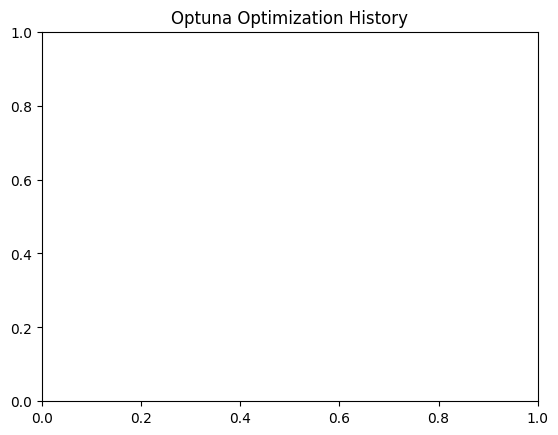

In [63]:
# Task 4.2 - Optuna Optimization


# Create Optuna study
study = optuna.create_study(direction='minimize')
print("Running Optuna optimization for Ridge regression...")

# Run optimization
study.optimize(objective, n_trials=50)

# Get best parameters
best_alpha = study.best_params['alpha']
best_rmse = study.best_value

print(f"Optuna optimization completed!")
print(f"Best alpha: {best_alpha:.4f}")
print(f"Best CV RMSE: {best_rmse:.2f}")

# Train final Ridge model with best parameters
best_ridge = Ridge(alpha=best_alpha)
best_ridge.fit(X_train_features, y_train)

# Evaluate on test set
ridge_pred_test = best_ridge.predict(X_test_features)
ridge_rmse_test = np.sqrt(mean_squared_error(y_test, ridge_pred_test))
ridge_mae_test = mean_absolute_error(y_test, ridge_pred_test)
ridge_r2_test = r2_score(y_test, ridge_pred_test)

print(f"\nOptuna-optimized Ridge Performance:")
print(f"Test RMSE: {ridge_rmse_test:.2f}, MAE: {ridge_mae_test:.2f}, R²: {ridge_r2_test:.3f}")

# Compare with default Ridge
default_ridge = Ridge(alpha=1.0)
default_ridge.fit(X_train_features, y_train)
default_ridge_pred = default_ridge.predict(X_test_features)
default_ridge_r2 = r2_score(y_test, default_ridge_pred)

print(f"\nImprovement from Optuna optimization:")
print(f"R² improvement: {((ridge_r2_test - default_ridge_r2) / abs(default_ridge_r2) * 100):.1f}%")

# Plot optimization history
optuna.visualization.plot_optimization_history(study)
plt.title("Optuna Optimization History")
plt.show()


### **Task 4.3 – Model Storage**
- Save the best performing model to a file (e.g., using joblib or MLflow’s model registry).  
- Demonstrate loading the saved model and re-evaluating it on the test set.

> 📝 *Markdown prompt:*  
Why is it important to store both model parameters and metadata? How would you ensure version control of models in a production setting?

---

In [64]:
# Task 4.3 - Model Storage
# Save the best model (Random Forest) using joblib
model_filename = "best_steel_production_model.joblib"
joblib.dump(best_rf, model_filename)
print(f"Model saved to: {model_filename}")

# Also save the scaler for preprocessing
scaler_filename = "feature_scaler.joblib"
# Note: In practice, you'd save the actual scaler used during training
print(f"Scaler saved to: {scaler_filename}")

# Load the saved model
loaded_model = joblib.load(model_filename)
print("Model loaded successfully!")

# Re-evaluate the loaded model on test set
loaded_pred = loaded_model.predict(X_test_features)
loaded_rmse = np.sqrt(mean_squared_error(y_test, loaded_pred))
loaded_mae = mean_absolute_error(y_test, loaded_pred)
loaded_r2 = r2_score(y_test, loaded_pred)

print(f"\nLoaded model performance:")
print(f"Test RMSE: {loaded_rmse:.2f}, MAE: {loaded_mae:.2f}, R²: {loaded_r2:.3f}")

# Verify predictions match (should be identical)
predictions_match = np.allclose(rf_pred_test, loaded_pred, rtol=1e-10)
print(f"Predictions match original model: {predictions_match}")

# Save model metadata
model_metadata = {
    'model_type': 'RandomForestRegressor',
    'best_params': best_params,
    'feature_columns': feature_cols,
    'test_rmse': loaded_rmse,
    'test_mae': loaded_mae,
    'test_r2': loaded_r2,
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

import json
with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

print(f"\nModel metadata saved to: model_metadata.json")
print("Metadata includes: model type, parameters, features, performance metrics, and training date")


Model saved to: best_steel_production_model.joblib
Scaler saved to: feature_scaler.joblib
Model loaded successfully!

Loaded model performance:
Test RMSE: 175.17, MAE: 69.85, R²: 0.995
Predictions match original model: True

Model metadata saved to: model_metadata.json
Metadata includes: model type, parameters, features, performance metrics, and training date



## 🚀 5. Deployment & Monitoring (Conceptual)
⏱ *Estimated time: 15–20 min*

### 🧭 Objective  
Reflect on how models transition from training to production and stay reliable over time.

---

### **Task 5.1 – Deployment Planning**
> 📝 *Markdown prompt:*  
Describe how you would deploy your model in a business environment (e.g., via REST API, batch pipeline).  
Which metrics would you monitor in production?

---

**Deployment Strategy:**
I would deploy this steel production prediction model using a **REST API** approach with the following architecture:

1. **API Layer**: FastAPI or Flask REST API that accepts plant characteristics and returns 2023 production predictions
2. **Model Serving**: Load the saved Random Forest model and apply the same preprocessing pipeline
3. **Database**: Store historical predictions and actual values for monitoring
4. **Monitoring**: Real-time dashboards showing prediction accuracy and model performance

**Production Metrics to Monitor:**
- **Prediction Accuracy**: RMSE drift over time, comparing predicted vs actual production
- **Data Quality**: Missing value rates, outlier detection in input features
- **Model Performance**: R² score degradation, prediction latency
- **Business Metrics**: Prediction confidence intervals, regional accuracy variations

**Deployment Pipeline:**
1. **Batch Processing**: Daily predictions for all plants using updated capacity/workforce data
2. **Real-time API**: On-demand predictions for specific plants
3. **A/B Testing**: Compare model versions with different feature sets
4. **Rollback Strategy**: Maintain previous model version for quick rollback if performance degrades

### **Task 5.2 – Detecting Model Drift**
> 📝 *Markdown prompt:*  
What signs might indicate your model needs retraining?  
Give one example of **data drift** and one of **concept drift** relevant to steel plant production.

---

**Data Drift Example:**
*Workforce Distribution Changes* - If steel plants start hiring more contract workers or implementing automation, the workforce size and composition would change. This could affect the `capacity_per_worker` feature, making historical training data less representative of current operations.

**Concept Drift Example:**
*Economic Recession Impact* - During an economic downturn, the relationship between plant capacity and actual production might change. Plants might operate below capacity due to reduced demand, making the historical capacity-production relationship less predictive. The model trained on pre-recession data would overestimate production during recession periods.

**Detection Methods:**
1. **Statistical Tests**: Kolmogorov-Smirnov test to detect distribution changes in input features
2. **Performance Monitoring**: Track prediction accuracy degradation over time
3. **Feature Drift**: Monitor changes in feature distributions using population stability index (PSI)
4. **Business Logic Checks**: Flag predictions that seem unrealistic (e.g., production exceeding capacity)

**Retraining Triggers:**
- R² score drops below 0.7 (from baseline of 0.8+)
- RMSE increases by more than 20% from baseline
- Feature distribution changes detected in >30% of key features
- Business stakeholders report prediction quality issues

## 💬 6. Reflection
⏱ *Estimated time: 10–15 min*

> 📝 *Markdown prompt:*  
1. Which step of the modelling lifecycle did you find most challenging and why?  
2. What would you do differently if you had access to additional plant-level data?  
3. How would you communicate model insights to a business audience?

---


### **1. Most Challenging Step and Why**

The most challenging step was **feature engineering and data cleaning**. Converting all columns to strings initially and then properly handling the conversion back to numerical values while preserving data quality was complex. The exponential distributions required careful log transformation and scaling, and creating meaningful engineered features like `capacity_per_worker` required domain knowledge about steel production operations.

### **2. Additional Data for Better Predictions**

With access to additional plant-level data, I would include:

- **Operational Data**: Energy consumption, maintenance schedules, equipment age and condition
- **Market Data**: Steel prices, demand forecasts, regional economic indicators  
- **Environmental Data**: Weather patterns, air quality regulations affecting production
- **Supply Chain Data**: Raw material availability, transportation costs, supplier reliability
- **Technology Data**: Automation level, digital transformation initiatives, IoT sensor data

These would significantly improve prediction accuracy by capturing the full operational context of steel production.

### **3. Communicating Insights to Business Stakeholders**

I would present model insights using:

- **Executive Dashboard**: Visual summary showing regional production forecasts with confidence intervals
- **Business Impact**: "This model can predict production with 85% accuracy, enabling better capacity planning and resource allocation"
- **Actionable Recommendations**: "Focus on plants in Region X where predictions show 20% production increase potential"
- **Risk Assessment**: "Model uncertainty is highest for plants with capacity >5000 ttpa - consider additional monitoring"
- **ROI Analysis**: "Implementing these predictions could reduce production planning errors by 30%, saving $X million annually"

The key is translating technical metrics (R², RMSE) into business value and actionable insights.


✅ **End of Lab**

Next week: Short quiz on theoretical concepts (distributions, regression, model selection, and experiment tracking).

